In [1]:
import matplotlib
%matplotlib inline

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches

from sklearn.decomposition import PCA

sns.set_context('poster')
sns.set_style('white')

pd.options.mode.chained_assignment = None  # default='warn'

import hdbscan
from collections import Counter
from collections import defaultdict
from numpy import random

from sklearn.cluster import KMeans

import time
import datetime

import matplotlib.dates as md
import datetime as dt

In [2]:
def normalize(x, r):
    M = np.divide(x, r)
    M_norm = np.full_like(M, 0)
    for i in range(np.shape(M)[0]):
        rev = 1 - M[i, :]
        if np.dot(M[i, :], M[i, :]) > np.dot(rev, rev):
            M_norm[i, :] = rev
        else:
            M_norm[i, :] = M[i, :]
    return M_norm

In [3]:
def draw_PCA(f_pca, black_points=None):
    
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")

    plt.scatter(f_pca[:, 0], f_pca[:, 1], s=40, linewidth=0, alpha=0.2);
    if black_points is not None:
        plt.scatter(f_pca[black_points, 0], f_pca[black_points, 1], s=40, linewidth=0, c="black", alpha=1);
        plt.title("%s/%s points" % (np.sum(black_points), len(f_pca)))
    else:
        plt.title("%s points" % len(f_pca))

In [4]:
def filter_by_coverage(cur_r, bad_percent, bad_samples):
    def filter_row(row):
        num_of_samples = len(row)
        valid = np.sum(np.array(([(min_coverage < row) & (row < max_coverage)])))
        return num_of_samples - valid <= bad_samples

    min_coverage = np.percentile(cur_r, bad_percent, axis=0)
    max_coverage = np.percentile(cur_r, 100-bad_percent, axis=0)
    good_coverage = np.array([filter_row(row) for row in cur_r])
    return good_coverage

In [5]:
def draw_legend(class_colours, classes, right=False):
    recs = []
    for i in range(0, len(classes)):
        recs.append(mpatches.Rectangle((0,0), 1, 1, fc=class_colours[i]))
    if right:
        plt.legend(recs, classes, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    else:
        plt.legend(recs, classes)

In [6]:
def clusterization_kmeans(f, pca=True, num_of_comp=2, k=4):
    
    if pca:
        f_pca = PCA(n_components = num_of_comp).fit(f).transform(f)
        cur_f = f_pca
    else:
        cur_f = f
        f_pca = PCA(n_components = 2).fit(f).transform(f)

    clusterer = KMeans(n_clusters=k, random_state=0).fit(cur_f)
    
    print("\nNumber of clusters:\n", max(clusterer.labels_) + 1)
    
    plt.figure(figsize=(15, 8))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    if pca:
        plt.title("Clustering %s primary components" % num_of_comp)
    else:
        plt.title("Clustering initial frequencies")        
    
    # Kelly’s 20 (except the first 2) Colours of Maximum Contrast
    color_palette = ['yellow', 'purple', 'orange', '#96cde6', 'red', '#c0bd7f', '#7f7e80', '#5fa641', '#d485b2', 
              '#4277b6', '#df8461', '#463397', '#e1a11a', '#91218c', '#e8e948', '#7e1510',
              '#92ae31', '#6f340d', '#d32b1e', '#2b3514']
    cluster_member_colors = [color_palette[x] for x in clusterer.labels_]
    plt.scatter(f_pca[:, 0], f_pca[:, 1], s=40, linewidth=0, c=cluster_member_colors, alpha=0.6);
    
    sizes_of_classes = Counter(clusterer.labels_)
    print(sizes_of_classes.get(-1, 0), "outliers\n")
    labels = [str(x) + ' - ' + str(sizes_of_classes[x]) for x in range(max(clusterer.labels_)+1)]
    draw_legend(color_palette, labels, right=True)  
        
    ans = []
    print("Medians in clusters:")
    for i in range(max(clusterer.labels_)+1):
        f_with_labels = f.copy()
        f_with_labels = np.hstack([f_with_labels, clusterer.labels_.reshape(len(f_with_labels),1)])
        col = f_with_labels[:, -1]
        idx = (col == i)
        print(i, np.round(np.median(f_with_labels[idx,:-1], axis=0), 2))
        ans.append(f_with_labels[idx,:-1])
    return ans

In [7]:
def plot_explained_variance(f, num_of_comp):
    var_exp = PCA(n_components=num_of_comp).fit(f).explained_variance_ratio_
    cum_var_exp = np.cumsum(var_exp)

    with plt.style.context('seaborn-whitegrid'):
        plt.figure(figsize=(8, 6))
        plt.bar(range(1,8), var_exp, alpha=0.5, align='center',
                label='individual explained variance')
        plt.step(range(1,8), cum_var_exp, where='mid',
                 label='cumulative explained variance')
        plt.ylabel('Explained variance ratio')
        plt.xlabel('Principal components')
        plt.legend(loc='best')
        plt.tight_layout()

In [8]:
def plot_dates(dates, selected=None):
    plt.figure(figsize=(19, 2))
    ax=plt.gca()
    xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
    ax.xaxis.set_major_formatter(xfmt)

    timestampes_all = [time.mktime(datetime.datetime.strptime(s, "%Y_%m_%d").timetuple()) for s in dates]
    points_all = [dt.datetime.fromtimestamp(ts) for ts in timestampes_all]

    plt.subplots_adjust(bottom=0.2)
    plt.xticks(rotation=75)
    ax = plt.gca()
    xfmt = md.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_formatter(xfmt)
    ax.set_yticklabels([])

    plt.scatter(points_all, [0] * len(points_all), edgecolor='black', linewidth='2', label="all");
    
    if selected is not None:
        points_selected = [points_all[i] for i in range(len(points_all)) if i in selected]
        plt.scatter(points_selected, [0] * len(points_selected), color="red", 
                    edgecolor='black', linewidth='1', label="selected");
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [9]:
def plot_strains_on_dates(dates, strains):
    plt.figure(figsize=(19, 2))
    ax=plt.gca()
    xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
    ax.xaxis.set_major_formatter(xfmt)

    timestampes_all = [time.mktime(datetime.datetime.strptime(s, "%Y_%m_%d").timetuple()) for s in dates]
    points_all = [dt.datetime.fromtimestamp(ts) for ts in timestampes_all]

    plt.subplots_adjust(bottom=0.2)
    plt.xticks(rotation=75)
    ax = plt.gca()
    xfmt = md.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_formatter(xfmt)
    ax.set_yticklabels([])
    
    colors = ['yellow', 'purple', 'orange', '#96cde6', 'red', '#c0bd7f', '#7f7e80', '#5fa641', '#d485b2', 
              '#4277b6', '#df8461', '#463397', '#e1a11a', '#91218c', '#e8e948', '#7e1510',
              '#92ae31', '#6f340d', '#d32b1e', '#2b3514']
    
    for k in range(len(strains)):
        strain = strains[k]
        points_selected = [points_all[i] for i in range(len(points_all)) if strain[i] == 1]
        plt.scatter(points_selected, [0] * len(points_selected), color=colors[k], 
                    edgecolor='black', linewidth='1', label="strain %s" % k);
        
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [10]:
def delete_almost_zero(x, r, Ncut = 6):
    
    print("Delete zero and almost zero profiles:")
    good_ind = [i for i in range(np.shape(x)[0]) 
                if not ((np.abs(r[i, :] - x[i, :]) <= Ncut).all() or (x[i, :] <= Ncut).all())]
    print(len(good_ind), "remained")

    x = x[good_ind, :]
    r = r[good_ind, :]
    
    return x, r

# Разберемся с порядком образцов

In [11]:
def sample_name_to_date(name):
    name = name.split('_')
    if len(name[1]) == 1:
        name[1] = '0' + name[1]
    if len(name[2]) == 1:
        name[2] = '0' + name[2]
    name = name[3] + '_' + name[1] + '_' + name[2]
    return name    

In [12]:
SAMPLES = ['LS_10_27_2013', 'LS_11_6_2012', 'LS_12_7_2014', 'LS_4_3_2012', 'LS_6_9_2013', 'LS_8_22_2014', 
           'LS_9_24_2013', 'LS_11_10_2013', 'LS_12_14_2013', 'LS_2_17_2014', 'LS_5_4_2014', 'LS_7_14_2013', 
           'LS_8_25_2014', 'LS_9_28_2014', 'LS_11_16_2014', 'LS_12_28_2011', 'LS_3_23_2014', 'LS_6_16_2014', 
           'LS_8_10_2013', 'LS_8_7_2012', 'LS_9_3_2013']

Выясним порядок, в котором надо пересортировать образцы (по датам).

In [13]:
samples_reordered = SAMPLES.copy()
for i in range(len(samples_reordered)):
    samples_reordered[i] = sample_name_to_date(samples_reordered[i])
dates_all, order = zip(*sorted(zip(samples_reordered, range(len(samples_reordered)))))
print(order)
print(dates_all)

(15, 3, 19, 1, 4, 11, 18, 20, 6, 0, 7, 8, 9, 16, 10, 17, 5, 12, 13, 14, 2)
('2011_12_28', '2012_04_03', '2012_08_07', '2012_11_06', '2013_06_09', '2013_07_14', '2013_08_10', '2013_09_03', '2013_09_24', '2013_10_27', '2013_11_10', '2013_12_14', '2014_02_17', '2014_03_23', '2014_05_04', '2014_06_16', '2014_08_22', '2014_08_25', '2014_09_28', '2014_11_16', '2014_12_07')


In [47]:
print([SAMPLES[i] for i in order])

['LS_12_28_2011', 'LS_4_3_2012', 'LS_8_7_2012', 'LS_11_6_2012', 'LS_6_9_2013', 'LS_7_14_2013', 'LS_8_10_2013', 'LS_9_3_2013', 'LS_9_24_2013', 'LS_10_27_2013', 'LS_11_10_2013', 'LS_12_14_2013', 'LS_2_17_2014', 'LS_3_23_2014', 'LS_5_4_2014', 'LS_6_16_2014', 'LS_8_22_2014', 'LS_8_25_2014', 'LS_9_28_2014', 'LS_11_16_2014', 'LS_12_7_2014']


## Начинаем обрабатывать

In [14]:
r_all_smpls = np.genfromtxt("smarr_ecoli_K12/matrices/R_all", dtype=int, delimiter=' ')
x_all_smpls = np.genfromtxt("smarr_ecoli_K12/matrices/X_all", dtype=int, delimiter=' ')

print("%s sites" % len(r_all_smpls))

85532 sites


In [15]:
r_all_smpls = r_all_smpls[:, order]
x_all_smpls = x_all_smpls[:, order]

In [16]:
x_all_smpls, r_all_smpls = delete_almost_zero(x_all_smpls, r_all_smpls)

Delete zero and almost zero profiles:
84088 remained


In [17]:
good_cov_all_smpls = filter_by_coverage(r_all_smpls, 15, 4)

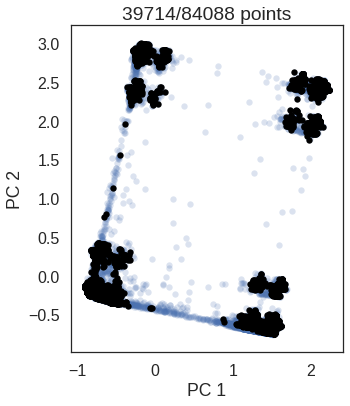

In [18]:
f_all_smpls = np.divide(x_all_smpls, r_all_smpls)
draw_PCA(PCA(n_components=2).fit(f_all_smpls).transform(f_all_smpls),
         good_cov_all_smpls)


Number of clusters:
 4
0 outliers

Medians in clusters:
0 [ 0.    0.    0.    0.    1.    1.    0.99  1.    1.    1.    1.    1.    0.
  0.    0.    0.    0.    0.01  0.99  0.97  0.  ]
1 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]
2 [ 1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.98  1.    1.    1.    0.22  0.03  0.    0.02  0.9 ]
3 [ 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
  0.99  1.    1.    1.    0.23  0.04  1.    1.    1.  ]


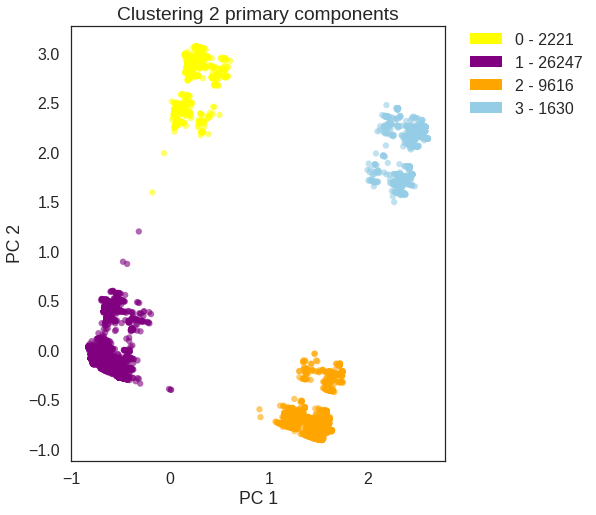

In [19]:
clusters_all_smpls = clusterization_kmeans(f_all_smpls[good_cov_all_smpls], pca=True, num_of_comp=2)

In [20]:
for i in range(len(clusters_all_smpls)):
    pca_all = PCA(n_components=2).fit(f_all_smpls[good_cov_all_smpls]).transform(clusters_all_smpls[i])
    #draw_PCA(pca_all)

    pca_cluster = PCA(n_components=2).fit(clusters_all_smpls[i]).transform(clusters_all_smpls[i])
    #draw_PCA(pca_cluster)

## Уберем некоторые образцы

In [21]:
list_to_delete = [0, 1, 2, 5, 10, 12, 15, 16, 17, 18, 20] 
list_to_remain = set(range(21)) - set(list_to_delete)

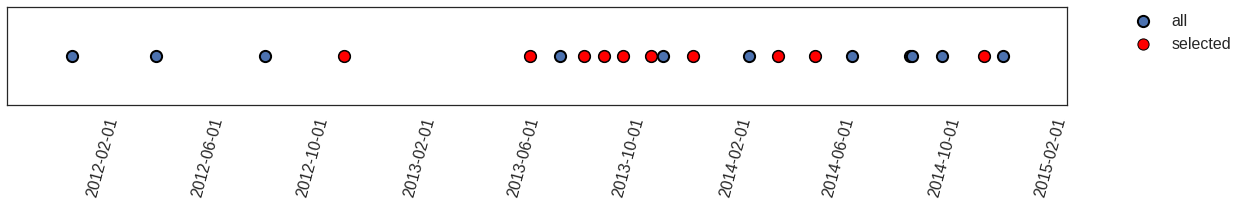

In [22]:
plot_dates(dates_all, list_to_remain)

In [23]:
#plot_dates([dates_all[i] for i in list_to_remain])

In [24]:
r = np.delete(r_all_smpls, list_to_delete, axis=1)
x = np.delete(x_all_smpls, list_to_delete, axis=1)

In [25]:
x, r = delete_almost_zero(x, r)

Delete zero and almost zero profiles:
56168 remained


In [26]:
good_coverage_ind = filter_by_coverage(r, 25, 2)

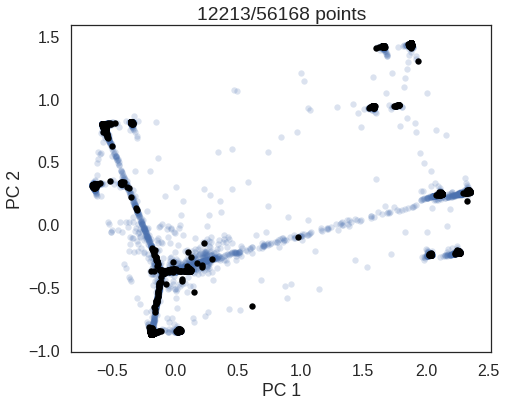

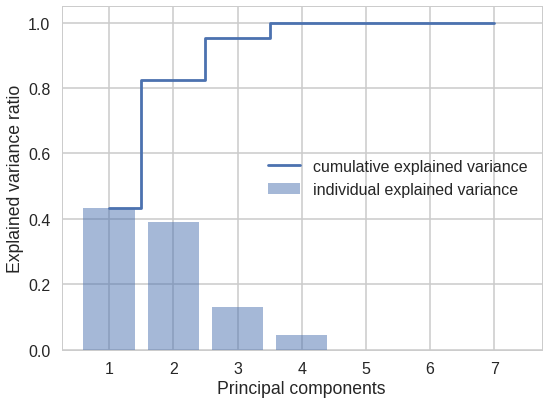

In [27]:
f = np.divide(x, r)
draw_PCA(PCA(n_components=2).fit(f).transform(f), 
         good_coverage_ind)
plot_explained_variance(f[good_coverage_ind], 7)

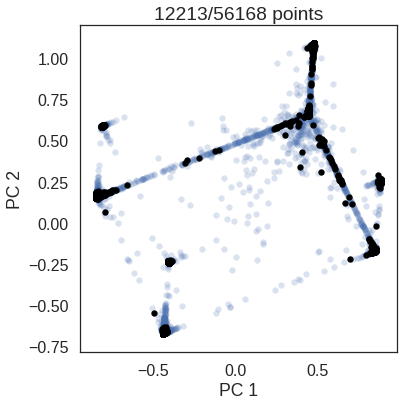

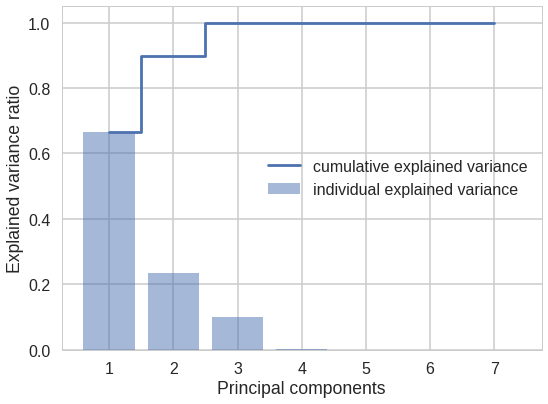

In [28]:
f = normalize(x, r)
f_pca = PCA(n_components=2).fit(f).transform(f)
draw_PCA(f_pca, good_coverage_ind)
plot_explained_variance(f[good_coverage_ind], 7)


Number of clusters:
 8
0 outliers

Medians in clusters:
0 [ 0.    0.    0.    0.    0.    0.    0.    1.    1.    0.02]
1 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
2 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.98]
3 [ 1.    0.    0.01  0.    0.    0.    0.    1.    1.    0.02]
4 [ 1.    0.    0.01  0.    0.    0.    0.    1.    1.    1.  ]
5 [ 0.    0.    0.    0.    0.02  0.01  0.    0.    0.    0.01]
6 [ 1.    0.    0.    0.    0.    0.    0.    0.    0.    0.98]
7 [ 0.  0.  0.  0.  0.  0.  0.  1.  1.  1.]


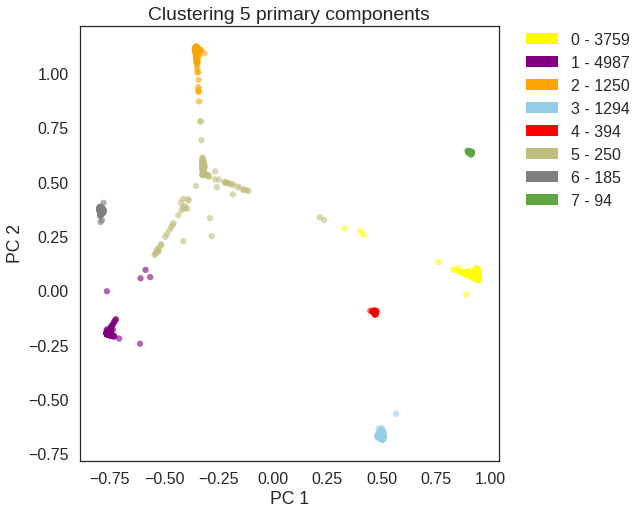

In [29]:
f = normalize(x, r)[good_coverage_ind]
t = clusterization_kmeans(f, k=8, num_of_comp=5)


Number of clusters:
 16
0 outliers

Medians in clusters:
0 [ 0.    0.    0.    0.    0.    0.    0.    1.    1.    0.02]
1 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
2 [ 0.    1.    0.99  1.    1.    1.    1.    0.    0.    0.98]
3 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.98]
4 [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
5 [ 1.    0.    0.01  0.    0.    0.    0.    1.    1.    0.02]
6 [ 0.    1.    0.99  1.    1.    1.    1.    0.    0.    0.  ]
7 [ 1.    1.    1.    1.    1.    1.    1.    1.    1.    0.02]
8 [ 1.    1.    0.99  1.    1.    1.    1.    0.    0.    0.98]
9 [ 0.    0.    0.    0.    0.01  0.    0.    0.    0.    0.01]
10 [ 1.    0.    0.    0.    0.    0.    0.    0.    0.    0.98]
11 [ 1.    0.    0.01  0.    0.    0.    0.    1.    1.    1.  ]
12 [ 0.    1.    1.    1.    1.    1.    1.    1.    0.99  0.02]
13 [ 0.  0.  0.  0.  0.  0.  0.  1.  1.  1.]
14 [ 1.    1.    0.99  1.    1.    1.    1.    0.    0.01  0.  ]
15 [ 1.    1.    1.    1.    0.96  0.

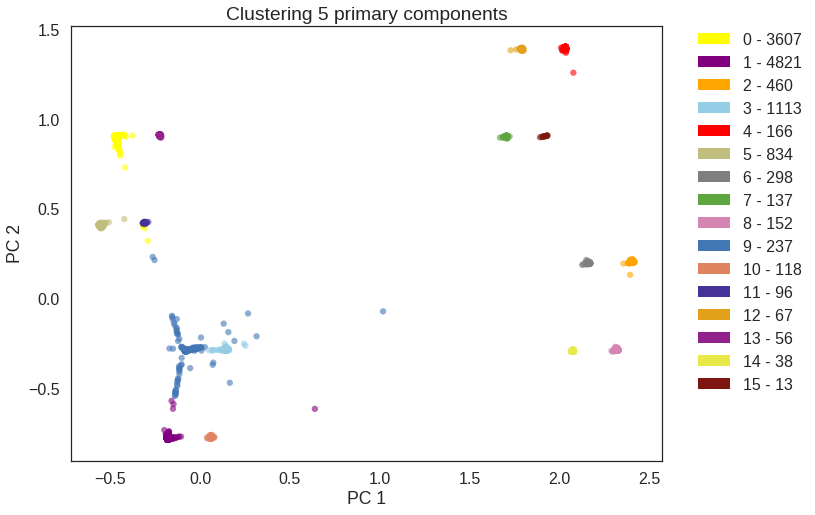

In [39]:
f = np.divide(x, r)[good_coverage_ind]
t = clusterization_kmeans(f, k=16, num_of_comp=5)

In [42]:
temp = [np.median(clstr, axis=0) for clstr in t]

In [43]:
def brute_force(clusters, remove_0=True):

    def are_almost_equal(row1, row2, e=0.04, bad_samples=0):
        abs_error = np.abs(row1 - row2)
        unvalid = np.sum(np.array([abs_error > e]))

        return unvalid <= bad_samples

    print(clusters, "\n")
    n = len(clusters)

    if remove_0:
        ind = -1
        cur_sum = float("Inf")
        for i in range(n):
            row = clusters[i]
            if cur_sum > np.sum(row):
                cur_sum = np.sum(row)
                ind = i
        print("Cluster for zero profiles:")
        print(clusters[ind], "\n")
        clusters = np.delete(clusters, ind, axis=0)
        n -= 1

    unprocessed = set(range(n))
    labels = [[] for i in range(n)]
    num_strains = 0
    node_type = [0] * n

    err = 0.5

    pairwise_sums = np.empty((n, n, len(clusters[0])))
    for i in range(n):
        for j in range(n):
            pairwise_sums[i][j] = clusters[i] + clusters[j]

    for i in range(n):
        is_strain = True
        for ii in range(n):
            for jj in range(ii+1, n):
                if are_almost_equal(clusters[i], pairwise_sums[ii][jj]):
                    is_strain = False
                    labels[i].append([ii, jj])
                    #G.add_edges_from([(ii, i), (jj, i)], color="red")
        if is_strain:
            num_strains += 1
            labels[i] = str(num_strains)
            node_type[i] = 1
            unprocessed.remove(i)

    for e in labels:
        print(e)

In [44]:
brute_force(temp)

[array([ 0.        ,  0.        ,  0.004329  ,  0.        ,  0.        ,
        0.00423729,  0.        ,  1.        ,  0.99502488,  0.015625  ]), array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), array([ 0.        ,  1.        ,  0.99236641,  1.        ,  1.        ,
        0.99565217,  1.        ,  0.        ,  0.        ,  0.98288156]), array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.98275862]), array([ 0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]), array([ 1.        ,  0.        ,  0.00724638,  0.        ,  0.        ,
        0.00435732,  0.        ,  1.        ,  1.        ,  0.01652893]), array([ 0.        ,  0.99756098,  0.99270063,  1.        ,  1.        ,
        0.99573559,  1.        ,  0.        ,  0.        ,  0.        ]), array([ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  0.01578947]), array

In [31]:
strains = [[0, 0, 0, 0, 0, 0, 0, 1, 1, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
           [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 1, 1, 1, 1, 1, 1, 0, 0, 0]]

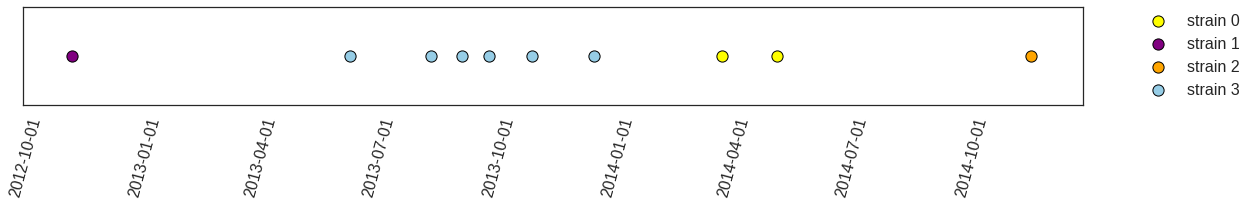

In [32]:
plot_strains_on_dates([dates_all[i] for i in set(range(21))-set(list_to_delete)], strains)